# **Glassdoor assessment**

## **Approach**

Below are the steps I have taken, in order, to arrive at the final results:

### Exploratory Data Analysis
1. Checked both slot_performance and location tables for missing values and duplicates and merged them based on city_id.
2. Performed Univariate Analysis to understand the distribution of all features and also performed Multivariate Analysis to understand the relationship between features.
3. Created a feature 'contract_active_duration' which is the duration for which the contract is active (end_date - start_date).

### Metric design
1. The level of data was employee_id + contract_id + state_name + city_name. Changed the level of data to employee_id by aggregation.
2. Created 4 new metrics - apps_per_clicks, cost_per_click, apps_per_listings and apps_per_contract_val by considering various features to measure the quality of services provided by Glassdoor clients. Analysed their relationship and correlation with 3 features - job_listings, total_contract_value, click_marketplace_value. (Detailed explanation in Metric Design section).

### Modelling
1. Checked correlation for all features and removed the ones with high correlation.
2. Used the remaining features to build an xgboost classification model to predict an employer's likelihood to retain.

# Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier 
import sklearn
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_columns', 500)
# To execute a cell line by line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Loading the data and overview

In [2]:
# To display quick overview of the data

def DataOverview(df):
    print('Shape of the Data:'+ str(df.shape) + '\n')   # To Find number of rows and columns
    print('Datatypes of Columns:',df.dtypes)            # Exploring the datatypes of the columns
    head = df.head()
    return head  

In [3]:
# To Find Total Count, Total #Unique values, Total #Missing values and Missing value percentage

def DescriptionTable(df):
    DescriptionTable = pd.DataFrame()
    DescriptionTable['TotalCount'] = df.count()             #Total number of values present in the columns
    DescriptionTable['MissingCount'] = df.isnull().sum()    #Total number of Missing values present in the columns
    DescriptionTable['MissingPercent'] = round((df.isnull().sum()/df.shape[0])*100, 2)    #Missing values percentage
    DescriptionTable.set_index(df.columns, inplace=True)    #Setting column names as index for dataframe
    return DescriptionTable  

In [4]:
slot_df = pd.read_excel('slot_performance table.xlsx')
DataOverview(slot_df)

Shape of the Data:(37757, 12)

Datatypes of Columns: employer_id                       float64
city_id                             int64
contract_id                         int64
start_date                 datetime64[ns]
end_date                   datetime64[ns]
renewed_flag                        int64
job_slots                           int64
total_contract_value                int64
applications                        int64
apply_start_clicks                  int64
click_marketplace_value           float64
job_listings                        int64
dtype: object


,employer_id,city_id,contract_id,start_date,end_date,renewed_flag,job_slots,total_contract_value,applications,apply_start_clicks,click_marketplace_value,job_listings
0,4.277920e+06,9767,2423796,2017-10-30 00:00:00.000,2017-11-30 23:59:59.000,1,15,995,215,255,15484.40,25
1,2.372987e+06,8585,2074128,2017-06-29 00:00:00.000,2017-07-29 23:59:59.000,0,50,1495,55,70,1719.30,50
2,1.142693e+06,6665,1924740,2017-05-02 00:00:00.000,2017-06-02 23:59:59.000,0,15,495,45,95,1195.75,20
3,1.353893e+06,5165,1942512,2017-05-09 00:00:00.000,2017-06-06 23:59:59.000,0,15,995,155,175,1197.35,20
4,9.224267e+05,3882,1380984,2016-09-19 15:14:21.707,2016-10-20 15:14:20.707,1,15,745,150,185,8889.70,20


In [5]:
slot_DescriptionTable = DescriptionTable(slot_df)
slot_DescriptionTable

,TotalCount,MissingCount,MissingPercent
employer_id,37757,0,0.0
city_id,37757,0,0.0
contract_id,37757,0,0.0
start_date,37757,0,0.0
end_date,37757,0,0.0
renewed_flag,37757,0,0.0
job_slots,37757,0,0.0
total_contract_value,37757,0,0.0
applications,37757,0,0.0
apply_start_clicks,37757,0,0.0


In [6]:
# Checking for duplicates

slot_df[slot_df.duplicated()]

,employer_id,city_id,contract_id,start_date,end_date,renewed_flag,job_slots,total_contract_value,applications,apply_start_clicks,click_marketplace_value,job_listings


In [7]:
loc_df = pd.read_excel('location table.xlsx')
DataOverview(loc_df)

Shape of the Data:(11458, 4)

Datatypes of Columns: city_id        int64
city_name     object
state_id      object
state_name    object
dtype: object


,city_id,city_name,state_id,state_name
0,1,Rockford,OH,Ohio
1,2,Sedgewickville,MO,Missouri
2,3,Whitehouse,OH,Ohio
3,4,Victor,IA,Iowa
4,5,Pacific Junction,IA,Iowa


In [8]:
loc_DescriptionTable = DescriptionTable(loc_df)
loc_DescriptionTable

,TotalCount,MissingCount,MissingPercent
city_id,11458,0,0.0
city_name,11458,0,0.0
state_id,11458,0,0.0
state_name,11458,0,0.0


In [9]:
# Checking for duplicates

loc_df[loc_df.duplicated()]

,city_id,city_name,state_id,state_name


We observe that there are no missing values and duplicates in both the tables.

In [10]:
# Merging both the tables

final_df = pd.merge(slot_df, loc_df, how='left', on = 'city_id')
final_df.shape
final_df.head()

(37757, 15)

,employer_id,city_id,contract_id,start_date,end_date,renewed_flag,job_slots,total_contract_value,applications,apply_start_clicks,click_marketplace_value,job_listings,city_name,state_id,state_name
0,4.277920e+06,9767,2423796,2017-10-30 00:00:00.000,2017-11-30 23:59:59.000,1,15,995,215,255,15484.40,25,Kaser,NY,New York
1,2.372987e+06,8585,2074128,2017-06-29 00:00:00.000,2017-07-29 23:59:59.000,0,50,1495,55,70,1719.30,50,Mexico,PA,Pennsylvania
2,1.142693e+06,6665,1924740,2017-05-02 00:00:00.000,2017-06-02 23:59:59.000,0,15,495,45,95,1195.75,20,Seagoville,TX,Texas
3,1.353893e+06,5165,1942512,2017-05-09 00:00:00.000,2017-06-06 23:59:59.000,0,15,995,155,175,1197.35,20,Tyrone,PA,Pennsylvania
4,9.224267e+05,3882,1380984,2016-09-19 15:14:21.707,2016-10-20 15:14:20.707,1,15,745,150,185,8889.70,20,Capitola,CA,California


In [11]:
# Checking for duplicates

final_df[final_df.duplicated()]

,employer_id,city_id,contract_id,start_date,end_date,renewed_flag,job_slots,total_contract_value,applications,apply_start_clicks,click_marketplace_value,job_listings,city_name,state_id,state_name


In [12]:
# Creating year, month and day columns for start and end dates

final_df['start_day'] = final_df['start_date'].dt.day
final_df['start_month'] = final_df['start_date'].dt.month
final_df['start_year'] = final_df['start_date'].dt.year

final_df['end_day'] = final_df['end_date'].dt.day
final_df['end_month'] = final_df['end_date'].dt.month
final_df['end_year'] = final_df['end_date'].dt.year

In [13]:
# Changing the data type of employer and contract ids

final_df['employer_id'] = final_df['employer_id'].map(int)
final_df['employer_id'] = final_df['employer_id'].map(str)
final_df['contract_id'] = final_df['contract_id'].map(str)

# Univariate analysis

Total States :  10


Pennsylvania    5637
Texas           5578
California      4840
Illinois        4373
Ohio            3896
New York        3443
Missouri        3401
Iowa            3238
Washington      2084
Oregon          1267
Name: state_name, dtype: int64

<Figure size 864x648 with 0 Axes>

Text(0.5, 1.0, 'Count of States')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

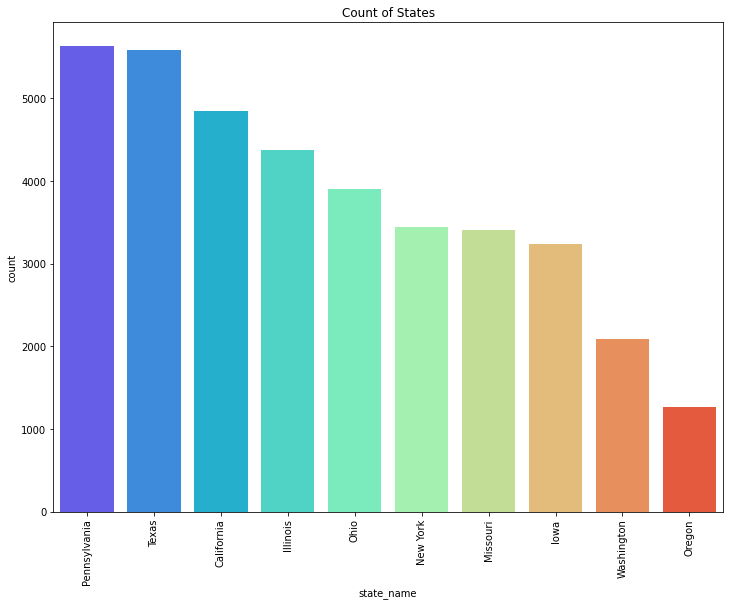

In [14]:
# Checking the distribution of states

print("Total States : ", final_df['state_name'].nunique())
final_df['state_name'].value_counts()

plt.figure(figsize=(12,9))
sns.countplot(x='state_name',data= final_df, order = final_df['state_name'].value_counts().index, palette='rainbow')
plt.title("Count of States")
plt.xticks(rotation=90)
plt.show()

In [15]:
# Checking the distribution of cities

print("Total Cities : ", final_df['city_name'].nunique())
final_df['city_name'].value_counts()

Total Cities :  8909


Riverside                     34
Waverly                       30
Newark                        30
Clayton                       29
Jacksonville                  29
                              ..
Paton                          1
Umatilla                       1
Gibsonia                       1
Prosper                        1
The Village of Indian Hill     1
Name: city_name, Length: 8909, dtype: int64

In [16]:
# Checking the minimum and maximum dates -  we have around 3 years of data

print("Minimum start date : " , final_df['start_date'].min())
print("Maximum start date : " ,final_df['start_date'].max())

print("Minimum end date : " , final_df['end_date'].min())
print("Maximum end date : " ,final_df['end_date'].max())

Minimum start date :  2016-04-09 00:00:00
Maximum start date :  2018-03-31 00:00:00
Minimum end date :  2016-04-11 17:15:54.350000
Maximum end date :  2018-04-30 23:59:59


In [17]:
# Checking count of customers
print("Total number of employers/Glassdoor customers : " , final_df['employer_id'].nunique())

# Checking count of contracts
print("Total number of contracts : " , final_df['contract_id'].nunique())

Total number of employers/Glassdoor customers :  11458
Total number of contracts :  37581


Total contract renewals :  2


1    26558
0    11199
Name: renewed_flag, dtype: int64

<Figure size 576x360 with 0 Axes>

Text(0.5, 1.0, 'Count of contract renewals (Renewed vs Non-Renewed)')

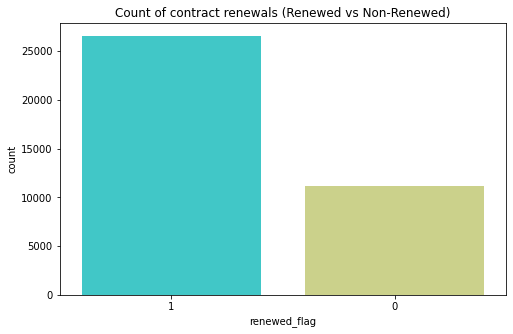

In [18]:
# Checking total number of contracts renewed vs non-renewed

print("Total contract renewals : ",final_df['renewed_flag'].nunique())
final_df['renewed_flag'].value_counts()

plt.figure(figsize=(8,5))
sns.countplot(x='renewed_flag',data=final_df, order = final_df['renewed_flag'].value_counts().index, palette='rainbow')
plt.title("Count of contract renewals (Renewed vs Non-Renewed)")
plt.show()

# Multivariate analysis

In [19]:
# Checking distribution of employers and contracts across different states

final_df.groupby(['state_name']).agg({'employer_id':'nunique', 'contract_id':'nunique'})

,employer_id,contract_id
state_name,,
California,3501,4838
Illinois,3307,4370
Iowa,2570,3237
Missouri,2724,3400
New York,2718,3441
Ohio,3005,3894
Oregon,1162,1267
Pennsylvania,3964,5637
Texas,3952,5570


In [20]:
# Checking distribution of Renewal rate across different states over years

state_renewal = final_df.groupby(['state_name', 'start_year']).agg({'renewed_flag':('sum','count'), 
                                                                                    'total_contract_value':'sum',
                                                                                    'applications':'sum',
                                                                                    'apply_start_clicks':'sum',
                                                                                    'click_marketplace_value':'sum'})
state_renewal.columns = state_renewal.columns.map('_'.join)
state_renewal.reset_index(inplace = True)
state_renewal['Renewal_rate'] = round((state_renewal['renewed_flag_sum']/state_renewal['renewed_flag_count'])*100,2)
state_renewal.sort_values('Renewal_rate', ascending=False)

,state_name,start_year,renewed_flag_sum,renewed_flag_count,total_contract_value_sum,applications_sum,apply_start_clicks_sum,click_marketplace_value_sum,Renewal_rate
28,Washington,2017,942,1248,1279650,56640,116615,2782766.70,75.48
25,Texas,2017,2451,3276,3324075,158845,318430,7513356.15,74.82
10,Missouri,2017,1508,2020,2008075,87315,185890,4671238.75,74.65
19,Oregon,2017,556,745,751455,32585,68575,1679295.45,74.63
22,Pennsylvania,2017,2525,3388,3394115,152235,316860,7474747.15,74.53
4,Illinois,2017,1870,2519,2566075,112260,232770,5643875.20,74.24
16,Ohio,2017,1683,2272,2300650,101520,207775,5001354.85,74.08
7,Iowa,2017,1372,1853,1885340,83025,176975,4161655.40,74.04
13,New York,2017,1512,2045,2047665,94300,199880,4802544.20,73.94
6,Iowa,2016,665,901,916215,45155,89075,2551377.15,73.81


# Feature engineering

In [21]:
# Calculating the duration for which the contract is active

final_df['contract_active_duration'] = (final_df['end_date'] - final_df['start_date']).dt.days

# Metric design

The data is at employer_id + contract_id + state_id + city_id level. I have combined the state and city columns. 

In [22]:
# Creating a column which is a combination of state and city

final_df['state_city'] = final_df['state_name'] + '_' + final_df['city_name']
final_df.shape

(37757, 23)

In [23]:
# Converting data to employee level

emp_df = final_df.groupby(['employer_id']).agg({'contract_id' :'nunique', 
                                                'renewed_flag':('count','sum'),
                                                'job_slots' : 'sum',
                                                'total_contract_value' : 'sum',
                                                'applications' : 'sum',
                                                'apply_start_clicks' : 'sum',
                                                'click_marketplace_value' : 'sum',
                                                'job_listings':'sum',
                                                'contract_active_duration':'sum',
                                                'state_city':'nunique'})
emp_df.columns = emp_df.columns.map('_'.join)
emp_df.reset_index(inplace = True)
emp_df.head()

,employer_id,contract_id_nunique,renewed_flag_count,renewed_flag_sum,job_slots_sum,total_contract_value_sum,applications_sum,apply_start_clicks_sum,click_marketplace_value_sum,job_listings_sum,contract_active_duration_sum,state_city_nunique
0,1001813,5,5,4,75,3725,60,130,2663.85,5,148,5
1,1002933,22,22,19,960,59345,5,11145,335876.40,340,613,22
2,1003120,11,11,10,165,5445,270,465,15031.25,40,323,11
3,1003786,3,3,2,45,3735,0,0,47.50,5,88,3
4,1004026,1,1,0,15,1745,0,0,11.70,0,30,1


In [24]:
emp_df['employer_id'].nunique()

11458

In [25]:
# Creating a renewal flag 

emp_df['Renewal_flag'] = emp_df['renewed_flag_sum']/emp_df['renewed_flag_count']
emp_df['Renewal_flag'] = np.where(emp_df['Renewal_flag'] > 0, 1, 0)

In order to measure the quality of services provided by Glassdoor to clients, I have come up with four metrics:
1. **apps_per_clicks** - This metric gives the percentage of applications received out of total number of start application clicks. This percentage should be as high as possible as we want to convert all the clicks.
2. **cost_per_click** - This metric gives the amount spent on each click. This should be as low as possible as we want to get maximum number of clicks for a given listing.
3. **apps_per_listings** - This metrics gives the number of applications received per given number of job listings. This metric should be as high as possible as we want to maximise the number of applications received from a given number of listings.
4. **apps_per_contract_val** - This metric talks about number of appliations received for a given contract value. This metric value should low as we want to maximise the number of applications received for a contract value.

In [26]:
# Creating metrics to measure quality of services

emp_df['apps_per_clicks'] = (emp_df['applications_sum']/emp_df['apply_start_clicks_sum'])*100
emp_df['cost_per_click'] = emp_df['apply_start_clicks_sum']/emp_df['click_marketplace_value_sum']
emp_df['apps_per_listings'] = emp_df['applications_sum']/emp_df['job_listings_sum']
emp_df['apps_per_contract_val'] = emp_df['applications_sum']/emp_df['total_contract_value_sum']

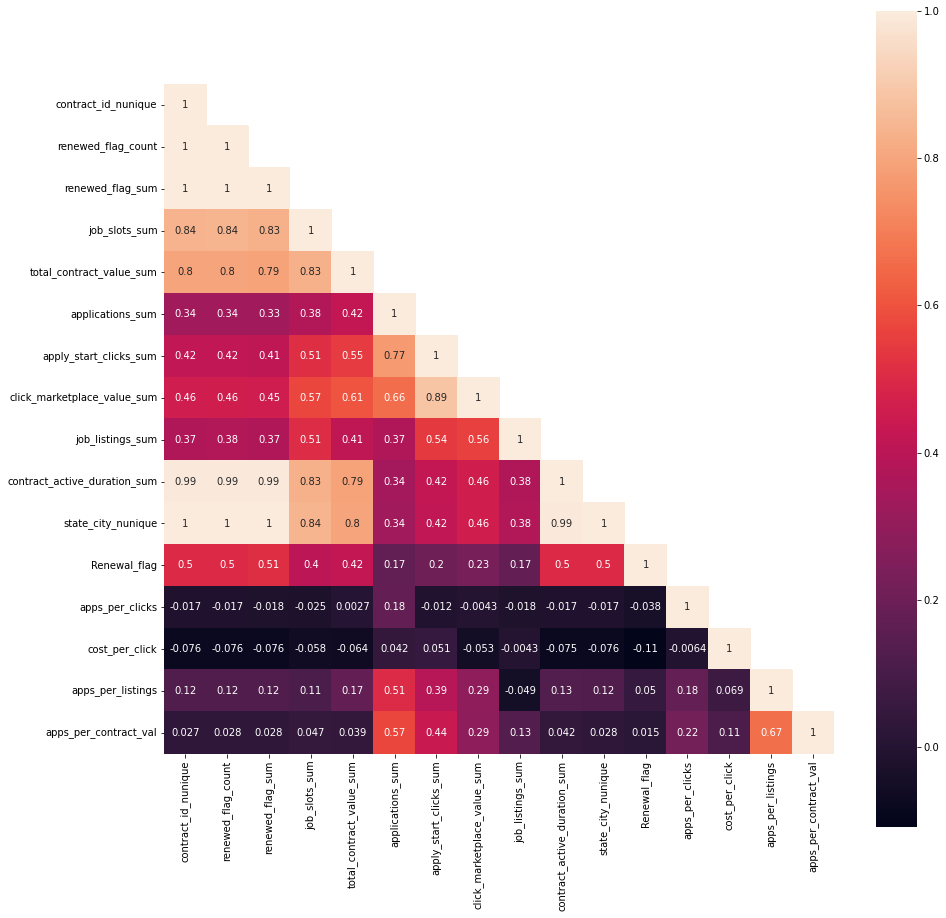

In [27]:
# Checking correlation between the features

cor_mat = emp_df[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(15,15)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

I tried to understand the correlation of these metrics with the existing features. I observed that:

1. **apps_per_clicks**

> *   **job_listings** - as number of job listings increase we expect that the clicks increase and thereby applications. This is also seen from the positive correlation of these variables with job_listings. In this case, apps_per_clicks should also be positively correlated with job_listings, but we observe that its negative. This maybe an indication of under performance.

> *   **total_contract_value** - this is positively correlated with apps_per_clicks which is expected as increase in total_contract_value increases clicks and thereby applications.

> *   **click_marketplace_value** - as click_marketplace_value increases we expect that the number of clicks increase and thereby applications. This is also seen from the positive correlation of these variables with click_marketplace_value. In this case, apps_per_clicks should also be positively correlated with click_marketplace_value, but we observe that its negative. This maybe an indication of under performance.


2. **cost_per_click**

> *   **job_listings** - as number of job listings increase we expect that the clicks increase and thereby click_marketplace_value. This is also seen from the positive correlation of these variables with job_listings. In this case, cost_per_click should also be positively correlated with job_listings, but we observe that its negative. This maybe an indication of under performance.

> *   **total_contract_value** - this is negatively correlated with cost_per_click which is the reverse of what's expected as increase in total_contract_value increases clicks and thereby click_marketplace_value.

> *   **click_marketplace_value** - as click_marketplace_value increases we expect that the number of clicks increase and thereby cost_per_click. This is also seen from the positive correlation of these variables with click_marketplace_value. In this case, apps_per_clicks should also be positively correlated with click_marketplace_value, but we observe that its negative. This maybe an indication of under performance.












In [28]:
emp_df.head(2)

,employer_id,contract_id_nunique,renewed_flag_count,renewed_flag_sum,job_slots_sum,total_contract_value_sum,applications_sum,apply_start_clicks_sum,click_marketplace_value_sum,job_listings_sum,contract_active_duration_sum,state_city_nunique,Renewal_flag,apps_per_clicks,cost_per_click,apps_per_listings,apps_per_contract_val
0,1001813,5,5,4,75,3725,60,130,2663.85,5,148,5,1,46.153846,0.048802,12.000000,0.016107
1,1002933,22,22,19,960,59345,5,11145,335876.40,340,613,22,1,0.044863,0.033182,0.014706,0.000084


In [29]:
# Dropping columns that are not necessary for modelling - state_city_nunique, contract_id_nunique and contract_active_duration_sum have high correlation

emp_df1 = emp_df.drop(columns = ['employer_id', 'renewed_flag_count', 'renewed_flag_sum', 'state_city_nunique', 'contract_active_duration_sum', 'contract_id_nunique'])

# Modelling

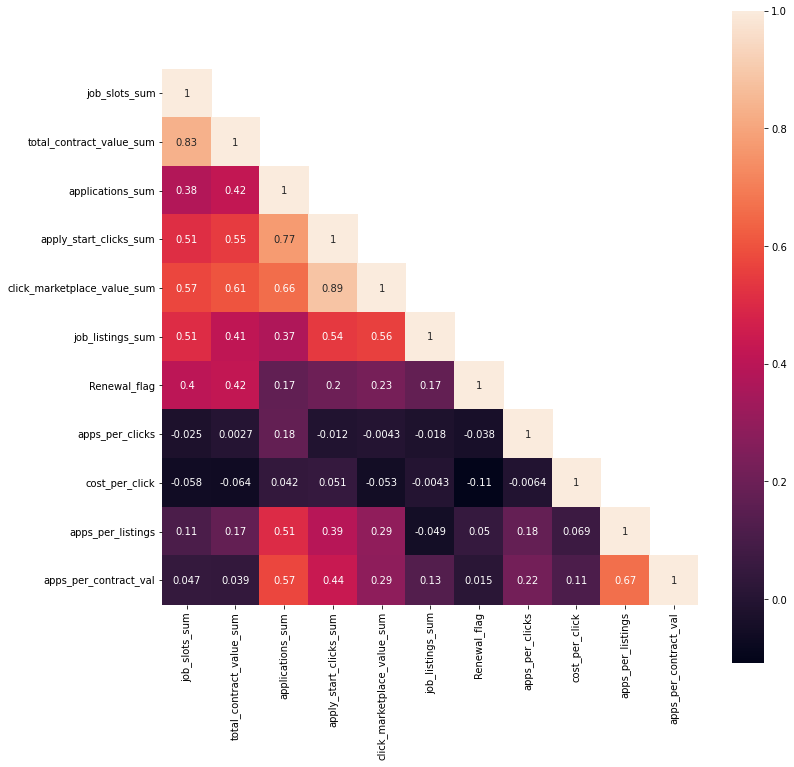

In [30]:
# Checking correlation between the features

cor_mat = emp_df1[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(12,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [31]:
# cat_columns_list = ["state_city"]
# for var in cat_columns_list:
#     lb = LabelEncoder()
#     temp = lb.fit_transform(final_df1[var])
#     final_df1[var] = lb.transform(np.array(final_df1[var]).astype('str'))

In [32]:
# Creating X and y varaibles to implement the model
X = emp_df1.drop(columns = ['Renewal_flag'])
y = emp_df1[['Renewal_flag']]

# Splitting the data into test and train datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=1)

In [33]:
NUMBER_KFOLDS = 5
RANDOM_STATE = 2018
VERBOSE_EVAL = 50
MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 

In [34]:
# Set xgboost parameters

params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE
#params['scale_pos_weight'] = 100

In [35]:
# Preparing the train and test data

dtrain = xgb.DMatrix(X_train, y_train.values)
dtest = xgb.DMatrix(X_test, y_test.values)

watchlist = [(dtrain, 'train'), (dtest, 'valid')]

In [36]:
# Building an xgboost model

model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.955649	valid-auc:0.947231
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.982757	valid-auc:0.97799
[100]	train-auc:0.983974	valid-auc:0.977796
Stopping. Best iteration:
[53]	train-auc:0.983065	valid-auc:0.978407



In [37]:
# Predicting response variable in train and test datasets

train_predict = model.predict(dtrain)
test_predict = model.predict(dtest)
test_predict = np.round(test_predict,0)

In [38]:
# Model evaluation metrics 

print("xGboost: Accuracy is", round(accuracy_score(y_test, test_predict),3))
print("xGboost: F1 score is", round(f1_score(y_test, test_predict),3))
print("xGboost: Precision is", round(precision_score(y_test, test_predict),3))
print("XGboost: Recall is", round(recall_score(y_test, test_predict),3))

xGboost: Accuracy is 0.965
xGboost: F1 score is 0.972
xGboost: Precision is 0.985
XGboost: Recall is 0.96


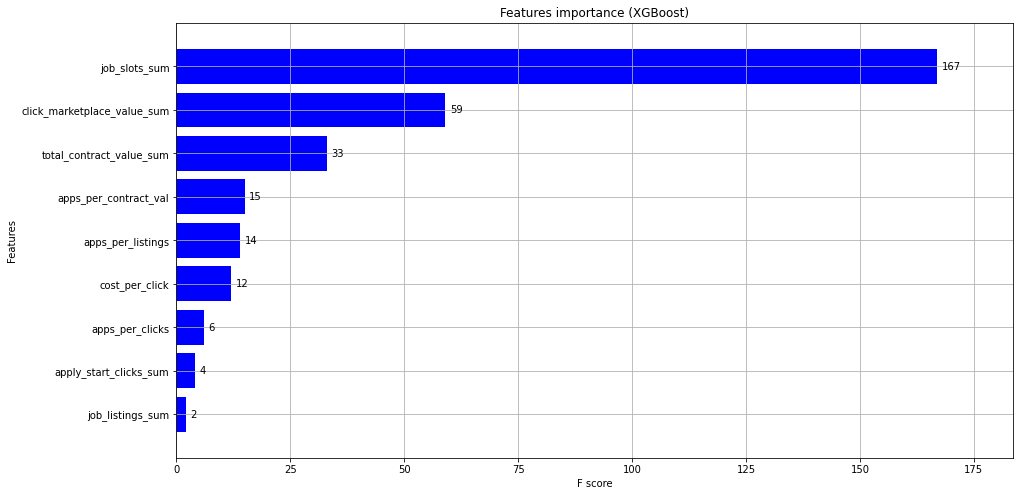

In [39]:
# Plotting feature importance for the model

fig, (ax) = plt.subplots(ncols=1, figsize=(15,8))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="blue") 
plt.show()

# Conclusion

1. I have tried combining different features together and the features in the final model are the ones which gave the best result compared to other combinations.
2. The final features that I have selected are - job_slots total_contract_value, applications, apply_start_clicks click_marketplace_value, job_listings,	Renewal_flag, apps_per_clicks, cost_per_click,	apps_per_listings, apps_per_contract_val.
3. I built an XGBoost classification model as it has high number of hyper-parameters that can be tuned, this is a primary advantage over gradient boosting machines. It also provides various intuitive features, such as parallelisation, distributed computing, cache optimisation, and more.
4. I was able to obtained a model with following evaultion metrics:
*   Accuarcy - 96.5%
*   F1 score - 97.2%
*   Precision - 98.5%
*   Recall - 96%
5. The model does a good job in predicting the classes correctly as it has high F-1 score.

Recommendations - I would consider other factors to improve the algorithm to predict retention:
1. Average time for which a job listing stays active, per contract. Meaning, how long after a job listing has been was the employer able to fill the position.
2. Converstion rate of applications. Meaning, how many of the applications are being hired for the roles.
